# Conditional GAN

### Problem definition

1. <p style='text-align: justify;'> Let's develop a GAN model that can generate NINIST digits, but based on the auxiliary input from the user indicating which digit to create. </p>


2. <p style='text-align: justify;'> To this end, the generate has to be trained to receive two different kinds of input: the random vector and the class label. </p>


3. <p style='text-align: justify;'> The random vector is easy to create. It should be a d-dimensional vector, sampled from a standard normal distribution $\mathcal{N}(0, 1)$. d = 100 worked just fine for me. </p>


4. <p style='text-align: justify;'> As for the conditioning vector, you somehow need to inform the network of your intention. For example, if you want to generate a "0", you need to give that information to the generator. There are many different ways to condition a neural network at various stages. But, this time, let's use a simple one. We will convert the digit label into a one-hot vector. For example, if you want to generate a "7" the conditioning vector is [0,0,0,0,0,0,0,1,0,0,]. </p>


5. <p style='text-align: justify;'> Then, we need to combine these two different kinds of information. Again, there are many different ways, but let's just stick to a simple solution. We will concatenate the d-dimensional random vector and the 10-dimensional one-hot vector. Therefore, the input to your generator is with d + 10 dimensions. If your d = 100. the input dimension is 110. </p>


6. <p style='text-align: justify;'> You are free to choose whatever network architecture you want to practice with. Here's the fully-connected one I found as a good starting point: 110 x 200 x 400 x 784. I used ReLU as the activation function, but as for the last layer. I used tanh. It means that I'll interpret —1 as the black pixel while +1 being the white pixel. </p>


7. <p style='text-align: justify;'> The discriminator has a similar architecture: 794 x 400 x 200 x 100 x 1. The reason why it takes a 794-dim vector is that it wants to know what the image sample is conditioned on. Also note that it does binary classification to discern whether the conditioned input image is a real or fake example, i.e., you will need to set up the last layer as a logistic regression function. </p>


8. <p style='text-align: justify;'> To train this GAN model, sample a minibatch of <i>B</i> examples from your MNIST dataset. These are your real examples. But, instead of feeding them directly to your discriminator, you'll append their label information by turning it into the one-hot representation. Don't forget to match the scale: it has to be from —1 to +1 instead of [0,1] as that's how the generator defines the pixel intensity. </p>


9. <p style='text-align: justify;'> Accordingly, generate a class-balanced set of fake examples by feeding <i>B</i> random vectors to your generator. Again, each of your random vectors needs to be appended by a randomly chosen one-hot vector. For example, if your <i>B</i> = 100, you may want to generate ten ones, ten twos, and so on. Although the generated images are not with any label information anymore, you know that each should belong to a particular digit class based on your conditioning vector. Therefore, when you feed these fake examples to the discriminator, you need to append the one-hot vectors once again. Of course, the one-hot vectors should match the one you used to inform the generator as input. </p>


10. <p style='text-align: justify;'> To summarize, the input to your generator is a d + 10-dim vector. The last 10 elements should be copied to augment your fake example, generated from the generator, to construct a 794-dim vector. You have <i>B</i> fake examples as such. The real examples are with the same size, but their first 784 elements are from the real MNIST images, accompanied by the last 10 elements representing the class, to which the image belongs. </p>


11. <p style='text-align: justify;'> Train this GAN model. I used Adam with lower-than-usual learning rates. Dropout helped the discriminator. Below is the figure that shows the change of the classification accuracy over the epochs (red for real and blue for fake examples). I can see that it converged to the Nash equilibrium, as the discriminator seems to be confused. </p>


<img src='assets/cgan_1.png' width="200"/>
     

12. <p style='text-align: justify;'> Below is the test maniples that I generated by feeding new random vectors (plus the intended class labels). I placed ten exmnples per class in a row. These are of course not the best MNIST digits I can imagine, but they look fine given the simple structure and algoritlun I used. </p>


<img src='assets/cgan_2.png' width="200"/>


13. <p style='text-align: justify;'> Please feel free to use whatever other things you want to try out, such as WGAN, but if your results are decent (like mine) we'll give away the full score. </p>



___

In [1]:
%matplotlib inline

import torch
import random
import numpy as np
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

## Checking if GPU is available

In [2]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available.')

Training on GPU!


## Loading dataset

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

In [4]:
training_set_count =  60000
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# conditioning vector

cond_vec = { 
    0: np.array([1,0,0,0,0,0,0,0,0,0]),
    1: np.array([0,1,0,0,0,0,0,0,0,0]),
    2: np.array([0,0,1,0,0,0,0,0,0,0]),
    3: np.array([0,0,0,1,0,0,0,0,0,0]),
    4: np.array([0,0,0,0,1,0,0,0,0,0]),
    5: np.array([0,0,0,0,0,1,0,0,0,0]),
    6: np.array([0,0,0,0,0,0,1,0,0,0]),
    7: np.array([0,0,0,0,0,0,0,1,0,0]),
    8: np.array([0,0,0,0,0,0,0,0,1,0]),
    9: np.array([0,0,0,0,0,0,0,0,0,1])
    }

### Visualize the data

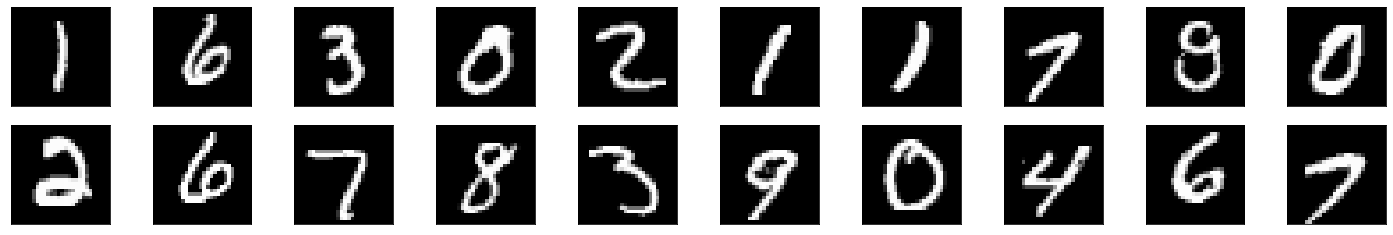

In [5]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


random_factor = random.randint(0, batch_size-20) # to show different subset from the dataset each run

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx+random_factor]), cmap='gray')

---
## Define the Model

Discriminator and Generator models

In [7]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, dropout=0.3):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.lrelu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28 + 10)
        
        # apply leaky relu activation to all hidden layers
        x = self.lrelu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.sigmoid(self.fc4(x))

        return x


In [8]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size, dropout=0.3):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.lrelu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):

        x = self.lrelu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.lrelu(self.fc3(x))
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        # final layer should have tanh applied
        x = self.tanh(x)
        
        return x

## Model hyperparameters

In [9]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28 + 10)
input_size = 784 + 10
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 100

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100 + 10
# Size of generator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 100

## Instantiating the models

In [10]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size, dropout=0.5)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

if(train_on_gpu):
    D.cuda()
    G.cuda()

Discriminator(
  (fc1): Linear(in_features=794, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc1): Linear(in_features=110, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (tanh): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)


## Creating loss functions

### Discriminator Losses
 - For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
 - For the real images, we want `D(real_images) = 1`.
 - The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`.

Note: To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9. For this, we'll use the parameter smooth; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`


### Generator Loss
- The generator's goal is to get `D(fake_images) = 1`

In [11]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    if smooth:
        labels = labels * 0.9
    
    if(train_on_gpu):
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if(train_on_gpu):
        labels = labels.cuda()
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, I'll define two separate Adam optimizers.

In [12]:
# learning rate for optimizers
lr = 0.0005

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As the model is training, I'll also print out some loss statistics and save some generated "fake" samples to keep track of the models' enhancement over epochs.

In [ ]:
%%time

# training hyperparams
num_epochs = 300

# keep track of loss, generated ("fake" samples) and acuracies
samples, losses = [], []
accuracy_real = np.zeros(num_epochs, dtype=np.float64)
accuracy_fake = np.zeros(num_epochs, dtype=np.float64)


# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 10 # 1 for each digit
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size-10))
fixed_z = np.concatenate(([cond_vec[i] for i in range(10)], fixed_z), axis=1)
fixed_z = torch.from_numpy(fixed_z).float()

if(train_on_gpu):
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, label) in enumerate(train_loader):

        real_images = real_images.detach().numpy()
        real_images = real_images.reshape(-1,28*28)
        real_images = torch.from_numpy(np.array(real_images)).float()

        if(train_on_gpu):
            real_images = real_images.cuda()
                
        batch_size = real_images.size(0)
        
        ## rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
            
        # 1. Train with real images

        # concatenate label code with real images
        
        labels = label.detach().numpy()
        labels = [cond_vec[l] for l in label.detach().numpy()]
        labels = torch.from_numpy(np.array(labels)).float()
        if(train_on_gpu):
            labels = labels.cuda()

        real_images = torch.cat((labels, real_images), 1)
         

        d_out = D(real_images)
        accuracy_real[epoch] += sum(d_out.cpu().detach().numpy())

        # Compute the discriminator losses on real images
        # use smoothed labels
        r_loss = real_loss(d_out, True)
        
        # 2. Train with fake images
        
        # Generate fake images and concatenating its label code
        z = np.random.uniform(-1, 1, size=(label.size(dim=0), z_size-10))
        lab = np.array([cond_vec[i//10] for i in range(label.size(dim=0))])
        z = np.concatenate((lab, z), axis=1)
        z = torch.from_numpy(z).float()
        lab = torch.from_numpy(lab).float()
        if(train_on_gpu):
            z, lab = z.cuda(), lab.cuda()

        fake_images = G(z)

        fake_images = torch.cat((lab, fake_images), 1)
        
        # Compute the discriminator losses on fake images        
        d_out = D(fake_images)
        f_loss = fake_loss(d_out)
        
        # add up real and fake losses and perform backprop
        d_loss = r_loss + f_loss
        
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(label.size(dim=0), z_size-10))
        lab = np.array([cond_vec[i//10] for i in range(label.size(dim=0))])
        z = np.concatenate((lab, z), axis=1)
        z = torch.from_numpy(z).float()
        lab = torch.from_numpy(lab).float()
        if(train_on_gpu):
            z, lab = z.cuda(), lab.cuda()

        fake_images = G(z)

        fake_images = torch.cat((lab, fake_images), 1)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        d_fake = D(fake_images)
        g_loss = real_loss(d_fake)   

        accuracy_fake[epoch] += sum(d_fake.cpu().detach().numpy())     
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    accuracy_real[epoch] /= training_set_count
    accuracy_fake[epoch] /= training_set_count

    # print discriminator and generator loss
    print('Epoch [{:3d}/{:3d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('/content/train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here will plot the training losses for the generator and discriminator, recorded after each epoch.

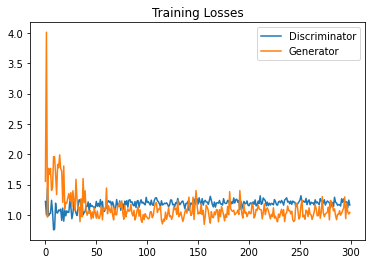

In [14]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Training accuracy

Here will plot the classification accuracy, recorded after each epoch.

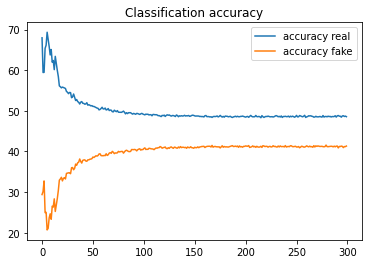

In [15]:
fig, ax = plt.subplots()
plt.plot(accuracy_real*100, label='accuracy real')
plt.plot(accuracy_fake*100, label='accuracy fake')
plt.title("Classification accuracy")
plt.legend()

## Generator samples from training

Here will can view samples of images from the generator. First we'll look at the images we saved during training.

In [16]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(15,15), nrows=1, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.cpu().reshape((28,28)), cmap='Greys_r')

In [17]:
# Load samples from generator, taken while training
with open('/content/train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

Below I'm showing the generated images as the network was training, every 10 epochs.

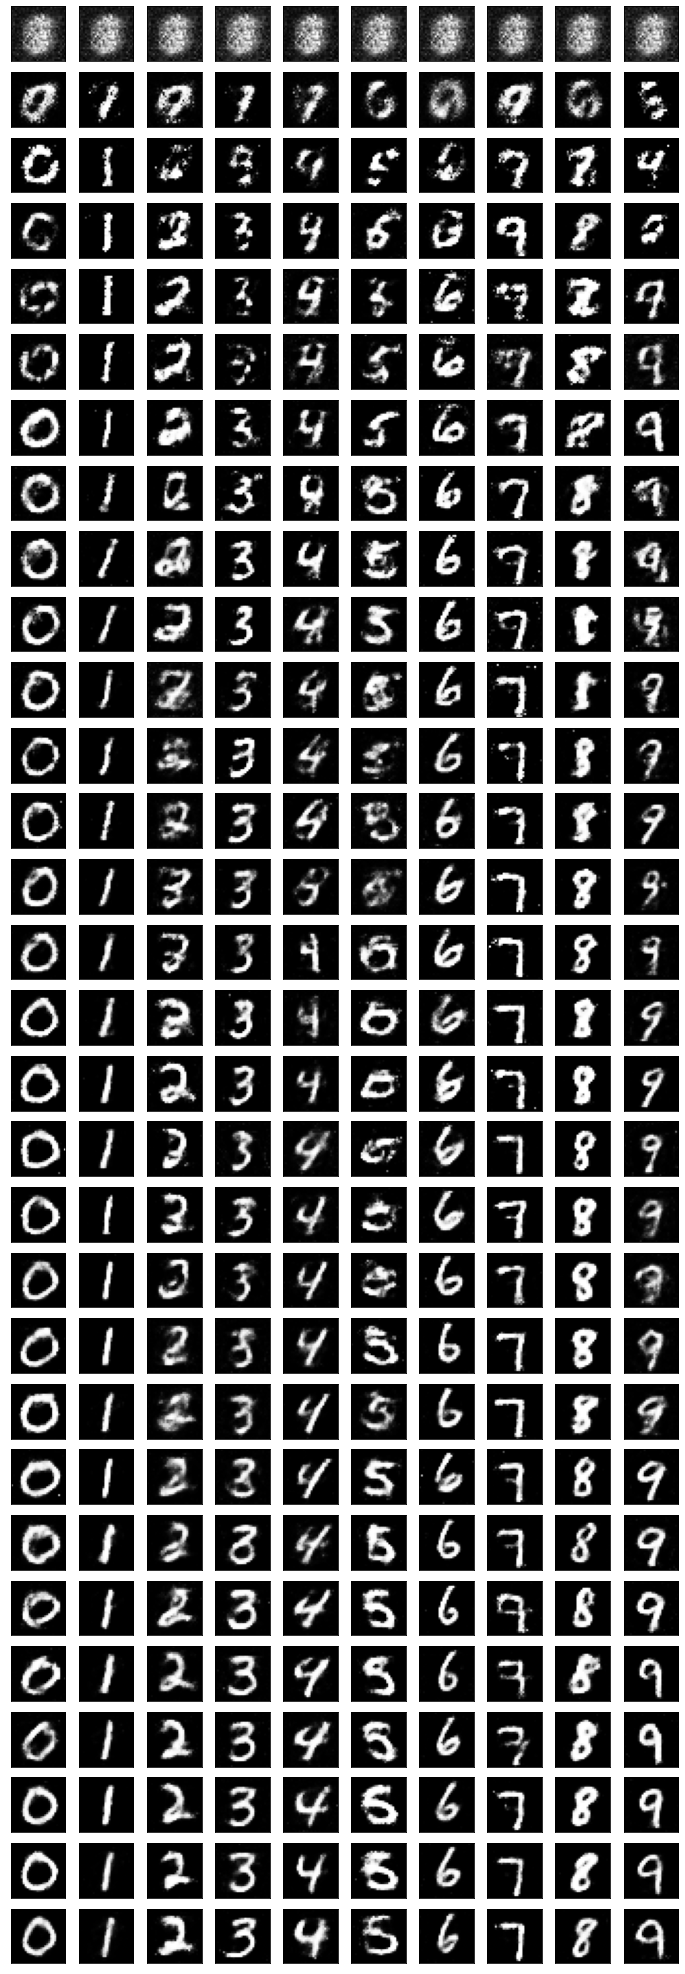

In [22]:
rows = num_epochs//10 # generated images every 10 epochs
cols = 10
fig, axes = plt.subplots(figsize=(12,36), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Generating 10 sample for ech digit

Generating new images from the generator . just need to pass in a new latent vector $z$, plus the conditioning vector and we'll get new samples

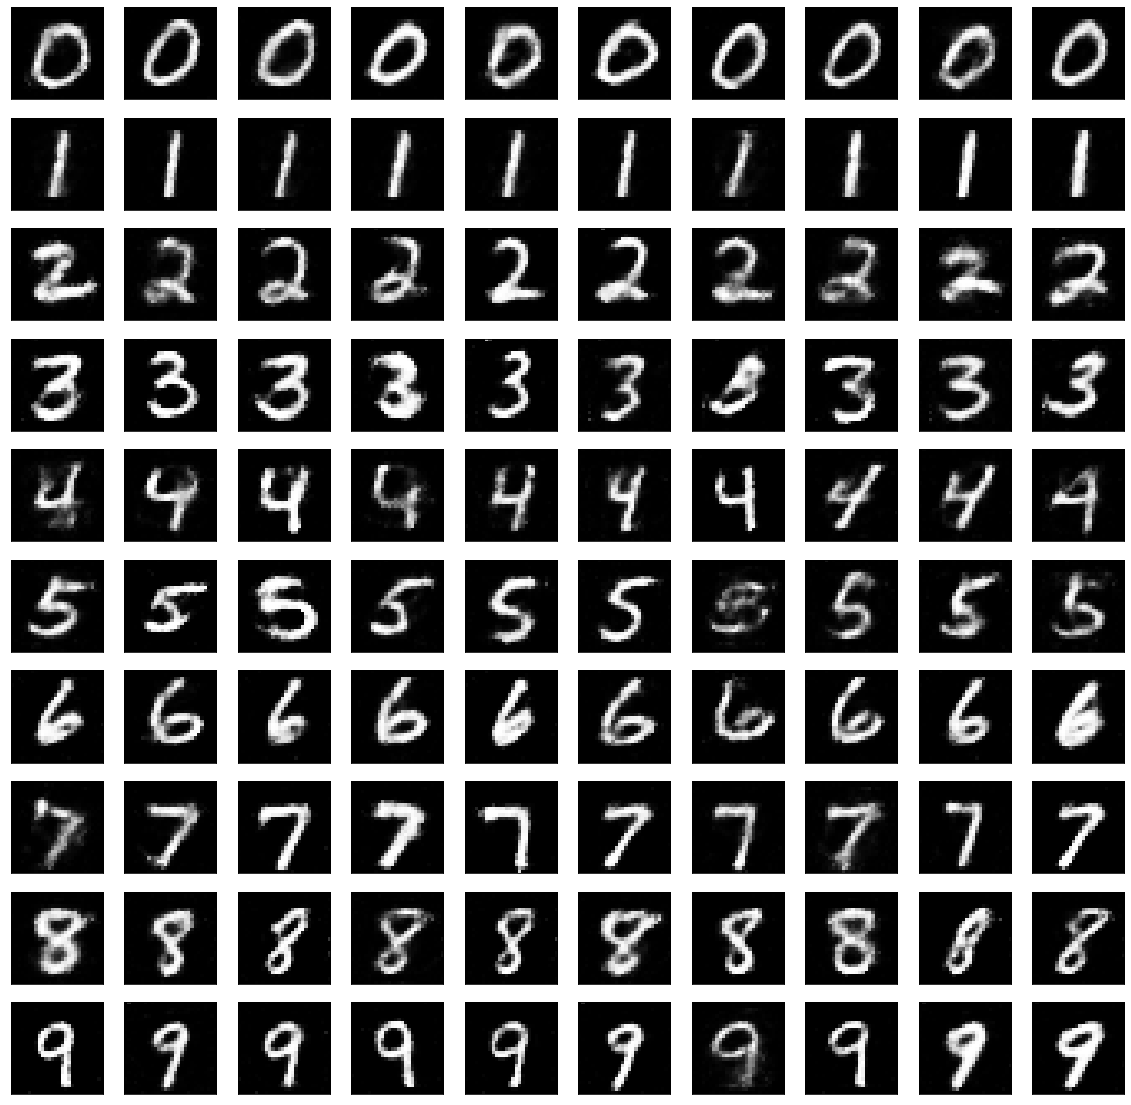

In [20]:
sample_size = 100
z = np.random.uniform(-1, 1, size=(sample_size, z_size-10))
lab = np.array([cond_vec[i//10] for i in range(sample_size)])
z = np.concatenate((lab, z), axis=1)
z = torch.from_numpy(z).float()
lab = torch.from_numpy(lab).float()
if(train_on_gpu):
    z, lab = z.cuda(), lab.cuda()

G.eval() # eval mode
fake_images = G(z)

fig = plt.figure(figsize=(20,20)) 
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + j + 1, xticks=[], yticks=[])
        ax.imshow(fake_images[i*10 + j].cpu().detach().numpy().reshape(28,28), cmap='gray');